### Author: Omarov Ruslan  
#### Итеративный алгоритм выделения контуров изображения

In [4]:
from PIL import Image
import math
from numpy import matrix
from numpy import linalg
import itertools
import cv2
from matplotlib import pyplot as plt

import numpy as np
from scipy.stats import multivariate_normal

file_name = "new-style.jpg"

im = Image.open(file_name)

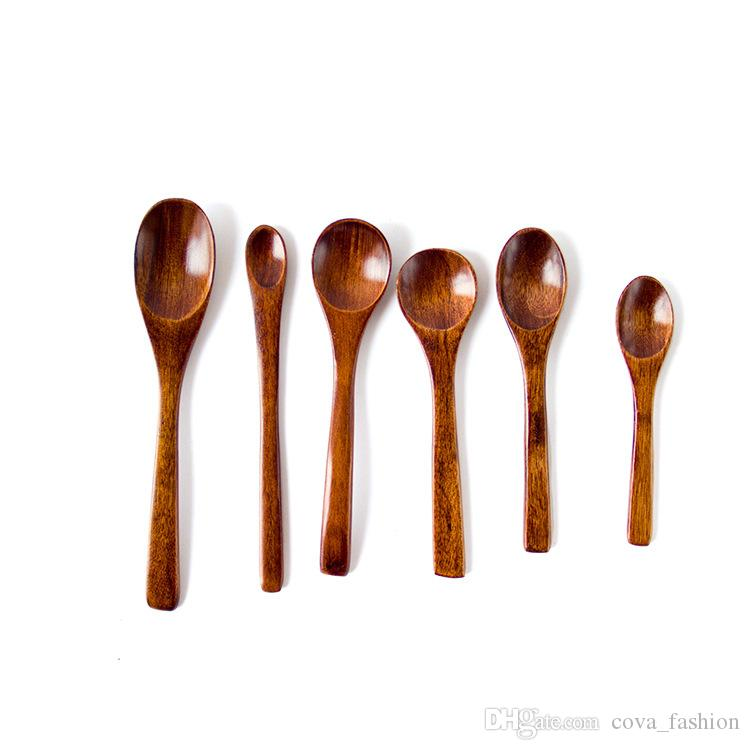

In [5]:
im

In [6]:
img = cv2.imread(file_name,0)
ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

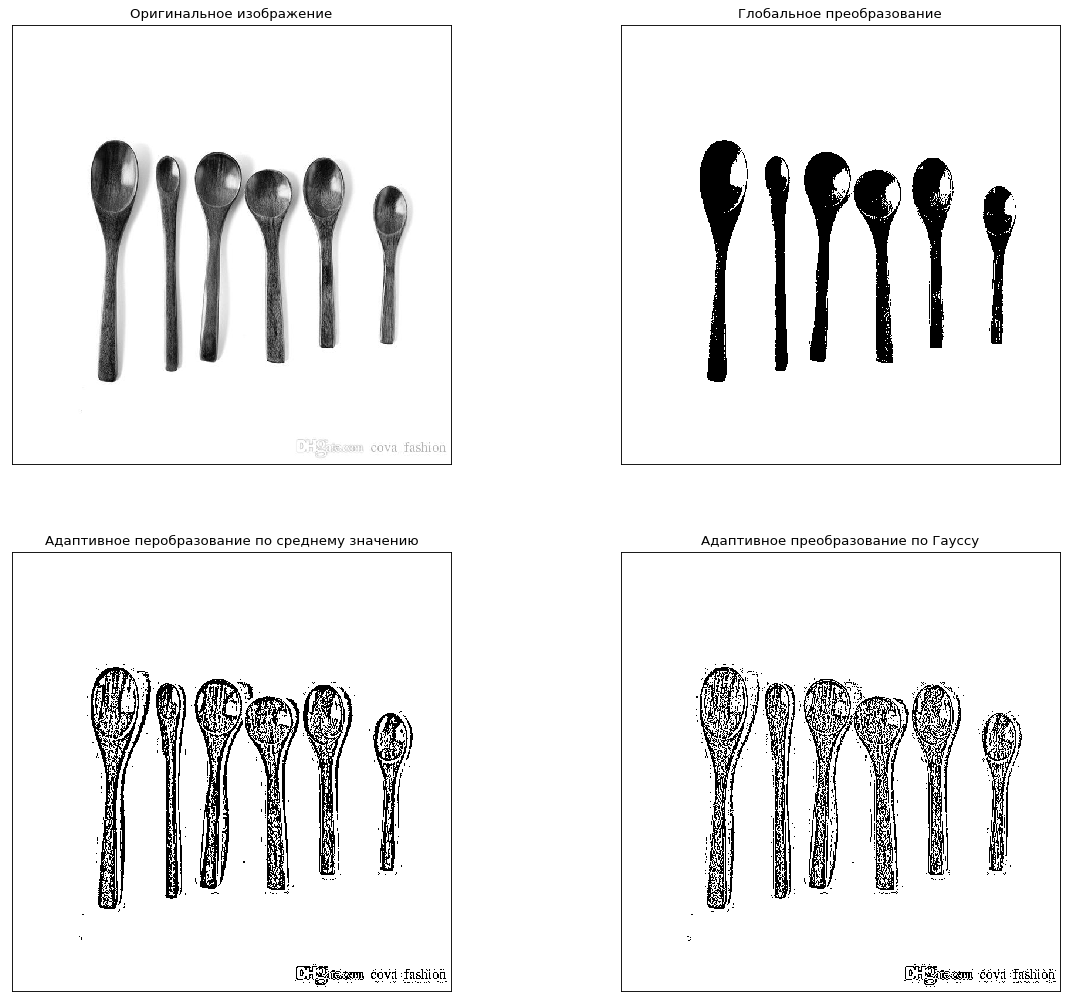

In [29]:
titles = ['Оригинальное изображение', 'Глобальное преобразование',
            'Адаптивное перобразование по среднему значению', 'Адаптивное преобразование по Гауссу']
images = [img, th1, th2, th3]
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [30]:
class MeanCalculator:
    def __init__(self):
        self.count = 0.
        self.mean = 0.

    def add(self, value, weight=1.):
        self.count += weight
        self.mean += weight * (value - self.mean) / self.count

    def remove(self, value, weight=1.):
        self.add(value, -weight)


        
class SumSquaredErrorsCalculator:
    def __init__(self):
        self.meanCalculator = MeanCalculator()
        self.SSE = 0.

    def add(self, value, weight=1.):
        curDiff = value - self.meanCalculator.mean
        self.meanCalculator.add(value, weight)
        self.SSE += weight * curDiff * (value - self.meanCalculator.mean)

    def remove(self, value, weight=1.):
        self.add(value, -weight)
        

class Pixel:
    def __init__(self, cl):
        self.cl = cl
        

def concat_classes(up, left):
    classes[up] = classes[up].union(classes[left])
    del classes[left]
    

def get_class_of_pixel(x, y):
    for item in classes:
        if (x, y) in classes[item]:
            return item

In [31]:
%%time
th1 = img
matr = [[0] * len(th1[0]) for i in range(len(th1))]
classes = {}
counter_of_classes = 1
means = {}
th = 20

for i in range(len(th1[0])):
    if i == 0:
        means[counter_of_classes] = MeanCalculator()
        means[counter_of_classes].add(th1[0][i])
        classes.setdefault(counter_of_classes, set()).add((0, 0))
    else:
        cl = get_class_of_pixel(0, i - 1)
        if abs(means[cl].mean - th1[0][i]) < th:
            means[cl].add(th1[0][i])
            classes.setdefault(cl, set()).add((0, i))

        else:
            counter_of_classes += 1
            means[counter_of_classes] = MeanCalculator()
            means[counter_of_classes].add(th1[0][i])
            classes.setdefault(counter_of_classes, set()).add((0, i))


for i in range(len(th1[1])):
    cl = get_class_of_pixel(0, i)
    if abs(means[cl].mean - th1[1][i]) < th:
        means[cl].add(th1[1][i])
        classes.setdefault(cl, set()).add((1, i))

    else:
        counter_of_classes += 1
        means[counter_of_classes] = MeanCalculator()
        means[counter_of_classes].add(th1[1][i])
        classes.setdefault(counter_of_classes, set()).add((1, i))


for i in range(2, len(th1)):
    for j in range(len(th1[0])):
        if j == 0:
            up = left = get_class_of_pixel(i - 1, 0)
        else:
            up = get_class_of_pixel(i - 1, 0)
            left = get_class_of_pixel(i, j - 1)
        up_th = means[up].mean
        left_th = means[left].mean
        
        if abs(th1[i-1][j] - th1[i][j]) > th and abs(th1[i][j-1] - th1[i][j]) > th:
            counter_of_classes += 1
            means[counter_of_classes] = MeanCalculator()
            means[counter_of_classes].add(th1[i][j])
            classes.setdefault(counter_of_classes, set()).add((i, j))

            
        elif abs(th1[i-1][j] - th1[i][j]) < th and abs(th1[i][j-1] - th1[i][j]) > th:
            means[up].add(th1[i][j])
            classes.setdefault(up, set()).add((i, j))

            
        elif abs(th1[i-1][j] - th1[i][j]) > th and abs(th1[i][j-1] - th1[i][j]) < th:
            means[left].add(th1[i][j])
            classes.setdefault(left, set()).add((i, j))
            
        else:
            if abs(means[up].mean - means[left].mean) < th:
                means[up].add(th1[i][j])
                if up != left:
                    concat_classes(up, left)
                classes.setdefault(up, set()).add((i, j))

            else:
                if abs(means[up].mean - th1[i][j]) > abs(means[up].mean - th1[i][j]):
                    means[left].add(th1[i][j])
                    classes.setdefault(left, set()).add((i, j))
                else:
                    means[up].add(th1[i][j])
                    classes.setdefault(up, set()).add((i, j))


/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in ubyte_scalars
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in ubyte_scalars
/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in ubyte_scalars


CPU times: user 2min 16s, sys: 15.8 ms, total: 2min 16s
Wall time: 2min 16s


In [11]:
len(classes)

38542

In [32]:
import collections
import itertools
import matplotlib.pyplot as plt


def flatten(listOfLists):
    "Flatten one level of nesting"
    return itertools.chain.from_iterable(listOfLists)
collections.Counter(flatten(th1))

Counter({255: 445963,
         254: 4364,
         253: 2816,
         251: 1513,
         252: 1853,
         250: 1127,
         249: 997,
         248: 847,
         247: 669,
         245: 518,
         244: 495,
         246: 632,
         242: 531,
         238: 468,
         237: 519,
         243: 476,
         233: 585,
         215: 703,
         173: 237,
         161: 191,
         152: 153,
         147: 139,
         133: 230,
         114: 428,
         104: 554,
         106: 498,
         123: 293,
         113: 388,
         127: 300,
         135: 227,
         137: 226,
         148: 185,
         165: 176,
         228: 712,
         212: 530,
         155: 186,
         98: 627,
         96: 655,
         78: 794,
         73: 762,
         76: 808,
         87: 729,
         89: 747,
         81: 778,
         80: 794,
         86: 802,
         75: 749,
         63: 753,
         67: 718,
         64: 742,
         54: 591,
         62: 718,
         82: 715,
  

In [237]:
th1.shape

(168, 300)

In [33]:
def make_colors(d):
    ls = list(d.items())
    ans = []
    while ls:
        col = set()
        new_ls = []
        el = ls[0]
        for i in range(1, len(ls)):
            if abs(el[1].mean - ls[i][1].mean) < th:
                col.add(ls[i][0])
            else:
                new_ls.append(ls[i])
        ans.append(col)
        ls = new_ls.copy()
    return ans
        
        

In [15]:
result = make_colors(means)

In [37]:
for item in classes:
    for i, j in classes[item]:
        th1[i][j] = item * 40 % 254


# for i in range(len(th1)):
#     for j in range(len(th1[0])):
#         th1[i][j] = matr[i][j]


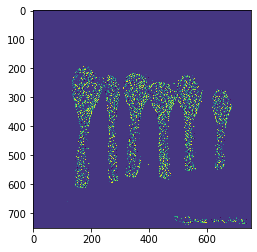

In [38]:
plt.imshow(th1)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fea61b4ab70>,
 <matplotlib.image.AxesImage at 0x7fea61b05390>)

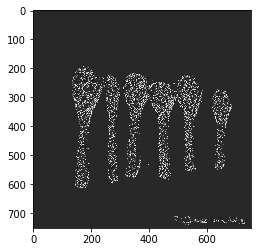

In [39]:
plt.subplot(1, 1, 1), plt.imshow(th1,'gray')

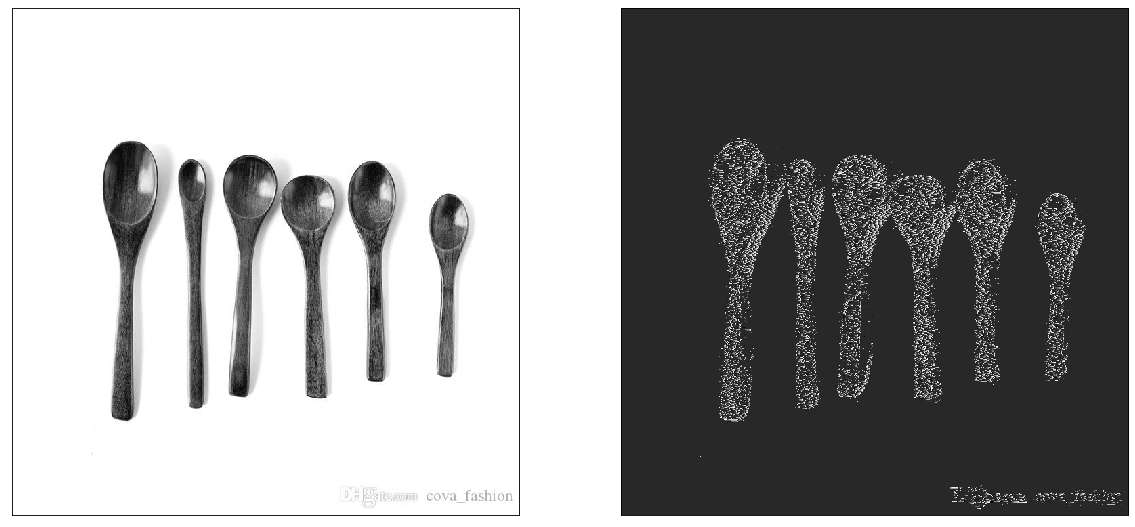

In [40]:

img = cv2.imread( "new-style.jpg",0)
images = [img, th1, th2, th3]
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(2):
    plt.subplot(1,2,i+1),plt.imshow(images[i],'gray')
    plt.xticks([]),plt.yticks([])
plt.show()

In [19]:
th1


array([[40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40],
       ...,
       [40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40],
       [40, 40, 40, ..., 40, 40, 40]], dtype=uint8)